In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import matplotlib.pyplot as plt
import pystan
%matplotlib inline

In [2]:
torndata = pd.read_csv('1950-2014_torn.csv', header=None)
torndata.columns = ['om', 'yr', 'mo', 'dy', 'date', 'time', 'tz', 'st', 'stf', 'stn', 'f', 'inj', 'fat', 'loss', 'closs', 'slat', 'slon', 'elat', 'elon', 'len', 'wid', 'ns', 'sn', 'sg', 'f1', 'f2', 'f3', 'f4']
torndata.head()

,om,yr,mo,dy,date,time,tz,st,stf,stn,f,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,ns,sn,sg,f1,f2,f3,f4
0,1,1950,1,3,1950-01-03,11:00:00,3,MO,29,1,3,3,0,6,0,38.77,-90.22,38.83,-90.03,9.5,150,2,0,1,0,0,0,0
1,1,1950,1,3,1950-01-03,11:00:00,3,MO,29,1,3,3,0,6,0,38.77,-90.22,38.82,-90.12,6.2,150,2,1,2,189,0,0,0
2,1,1950,1,3,1950-01-03,11:10:00,3,IL,17,1,3,0,0,5,0,38.82,-90.12,38.83,-90.03,3.3,100,2,1,2,119,0,0,0
3,2,1950,1,3,1950-01-03,11:55:00,3,IL,17,2,3,3,0,5,0,39.10,-89.30,39.12,-89.23,3.6,130,1,1,1,135,0,0,0
4,3,1950,1,3,1950-01-03,16:00:00,3,OH,39,1,1,1,0,4,0,40.88,-84.58,0.00,0.00,0.1,10,1,1,1,161,0,0,0


In [3]:
torndatasel = torndata[np.logical_and(np.logical_and(torndata['f'] == 3, torndata['yr'] >= 2000), torndata['sn'] == 1)]
torndatasel.head()

,om,yr,mo,dy,date,time,tz,st,stf,stn,f,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,ns,sn,sg,f1,f2,f3,f4
41107,626,2000,1,3,2000-01-03,13:30:00,3,MS,28,2,3,0,0,0.45,0,34.17,-89.55,34.60,-89.08,43.2,500,1,1,1,161,71,145,0
41108,628,2000,1,3,2000-01-03,15:08:00,3,KY,21,1,3,3,0,7.40,0,37.27,-88.08,37.48,-87.73,24.0,440,1,1,1,55,233,0,0
41109,19,2000,1,3,2000-01-03,16:06:00,3,KY,21,2,3,18,0,64.00,0,37.72,-87.18,37.77,-87.12,7.0,880,1,1,1,59,0,0,0
41127,634,2000,2,13,2000-02-13,22:42:00,3,GA,13,2,3,175,11,20.00,0,31.17,-84.27,31.23,-84.12,9.2,300,1,1,1,205,0,0,0
41128,635,2000,2,13,2000-02-13,23:49:00,3,GA,13,3,3,15,7,5.00,0,31.02,-84.20,31.07,-84.02,15.0,300,1,1,1,131,275,205,0


In [4]:
years = torndatasel['yr'].unique()
yearsdict = {}
for i in xrange(len(years)):
    yearsdict[years[i]] = i

In [5]:
landdata = pd.read_csv('DEC_10_DP_G001_with_ann.csv', skiprows=1, header=0, index_col='Id2')
landdata = landdata['AREA CHARACTERISTICS - Area (Land)']
landdata.head()

Id2
1001    1539582278
1003    4117521611
1005    2291818968
1007    1612480789
1009    1669961855
Name: AREA CHARACTERISTICS - Area (Land), dtype: int64

In [6]:
counties = landdata.index.values
countiesdict = {}
for i in xrange(len(counties)):
    countiesdict[counties[i]] = i

In [7]:
popdata = pd.read_csv('PEP_2014_PEPANNRES_with_ann.csv', skiprows=1, header=0, index_col='Id2')
popdata = popdata['April 1, 2010 - Census']
popdata.head()

Id2
1001     54571
1003    182265
1005     27457
1007     22915
1009     57322
Name: April 1, 2010 - Census, dtype: int64

In [8]:
torndatasel['pop_dens'] = 0 # need better way to make column

/home/stephen/miniconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [9]:
for i in torndatasel.index:
    population = 0.
    area = 0.
    density = 0.
    row = torndatasel.loc[i]
    for column in ['f1', 'f2', 'f3', 'f4']:
        county = row[column]
        if county != 0:
            county += row['stf'] * 1000
            population += popdata[county]
            area += landdata[county]
    torndatasel.loc[i, 'pop_dens'] = population / float(area)#dens
torndatasel.head()

/home/stephen/miniconda/lib/python2.7/site-packages/pandas/core/indexing.py:411: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,om,yr,mo,dy,date,time,tz,st,stf,stn,f,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,ns,sn,sg,f1,f2,f3,f4,pop_dens
41107,626,2000,1,3,2000-01-03,13:30:00,3,MS,28,2,3,0,0,0.45,0,34.17,-89.55,34.60,-89.08,43.2,500,1,1,1,161,71,145,0,0.000022
41108,628,2000,1,3,2000-01-03,15:08:00,3,KY,21,1,3,3,0,7.40,0,37.27,-88.08,37.48,-87.73,24.0,440,1,1,1,55,233,0,0,0.000013
41109,19,2000,1,3,2000-01-03,16:06:00,3,KY,21,2,3,18,0,64.00,0,37.72,-87.18,37.77,-87.12,7.0,880,1,1,1,59,0,0,0,0.000081
41127,634,2000,2,13,2000-02-13,22:42:00,3,GA,13,2,3,175,11,20.00,0,31.17,-84.27,31.23,-84.12,9.2,300,1,1,1,205,0,0,0,0.000018
41128,635,2000,2,13,2000-02-13,23:49:00,3,GA,13,3,3,15,7,5.00,0,31.02,-84.20,31.07,-84.02,15.0,300,1,1,1,131,275,205,0,0.000024


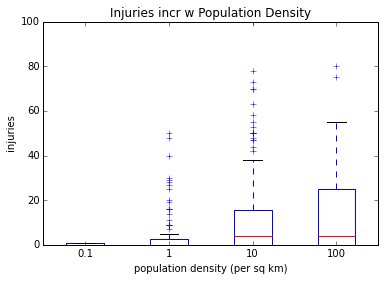

In [10]:
plt.boxplot([(torndatasel[np.log10(torndatasel['pop_dens'].values) // 1 == y])['inj'].values for y in [-7, -6, -5, -4]])
plt.ylim((0,100))
plt.xlabel('population density (per sq km)')
plt.ylabel('injuries')
plt.xticks([1,2,3,4],[0.1,1,10,100])
plt.title('Injuries incr w Population Density')
plt.show()

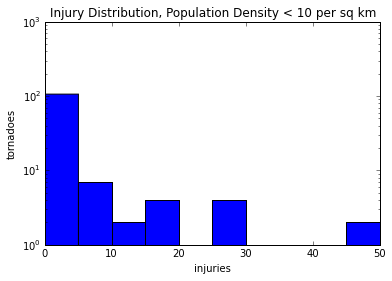

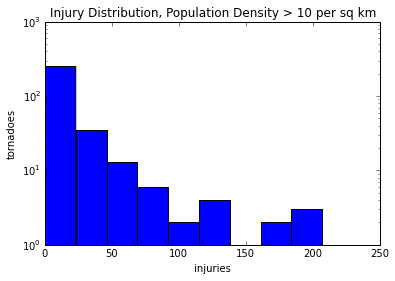

In [11]:
plt.hist(torndatasel[torndatasel['pop_dens'] < 1e-5]['inj'].values, log=True)
plt.xlabel('injuries')
plt.ylabel('tornadoes')
plt.title('Injury Distribution, Population Density < 10 per sq km')
plt.show()
plt.hist(torndatasel[torndatasel['pop_dens'] > 1e-5]['inj'].values, log=True)
plt.xlabel('injuries')
plt.ylabel('tornadoes')
plt.title('Injury Distribution, Population Density > 10 per sq km')
plt.show()

In [12]:
tornado_model = """
data {
    int<lower=0> N_torn; // Number of tornados
    real<lower=0> popdens[N_torn]; // effective population density
    int<lower=0> y[N_torn]; // number of injuries
}
parameters {
    real const_factor;
    vector[N_torn] noise_factor;
    real<lower=0> noise_hp_sig;
}
transformed parameters {
    real lambda[N_torn];
    for (i in 1:N_torn) {
        lambda[i] <- popdens[i] * exp(const_factor + noise_factor[i]);
    }
}
model  {
    y ~ poisson(lambda);
    
    noise_factor ~ normal(0, noise_hp_sig);
}
"""

In [13]:
tornado_dat = {'N_torn':len(torndatasel.index),
               'popdens':torndatasel['pop_dens'].values,
               'y':torndatasel['inj'].values}

In [14]:
niter = 10000
fit = pystan.stan(model_code=tornado_model, data=tornado_dat, iter=2*niter, chains=1)

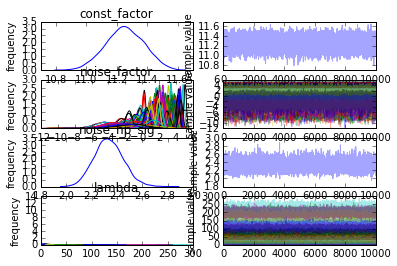

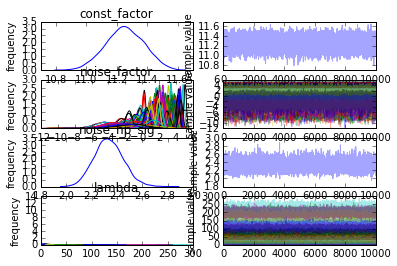

In [15]:
fit.plot()

In [16]:
extract = fit.extract(permuted=True)

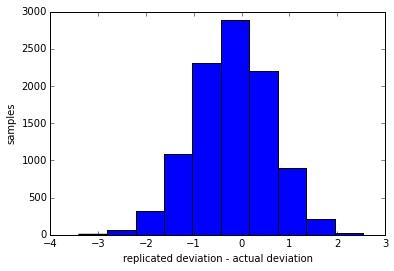

In [17]:
TS = []

for i in xrange(niter):
    noise_hp_sig = extract['noise_hp_sig'][i]
    noise_factor = extract['noise_factor'][i]
    const_factor = extract['const_factor'][i]
    
    predinjuries = torndatasel['pop_dens'].values * np.exp(const_factor)
    lambdas = torndatasel['pop_dens'].values * np.exp(const_factor + noise_factor)
    injuries = np.random.poisson(lam=lambdas)
    sqres = np.sqrt(np.mean(np.power(injuries - predinjuries, 2)))
    
    realsqres = np.sqrt(np.mean(np.power(torndatasel['inj'].values - predinjuries, 2)))
    TS.append(realsqres - sqres)
    
plt.hist(TS)
plt.xlabel('replicated deviation - actual deviation')
plt.ylabel('samples')
plt.show()

Predicted injuries: 5723
Actual injuries: 5628


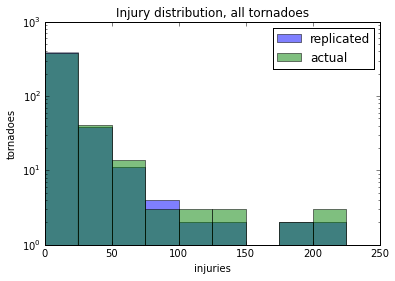

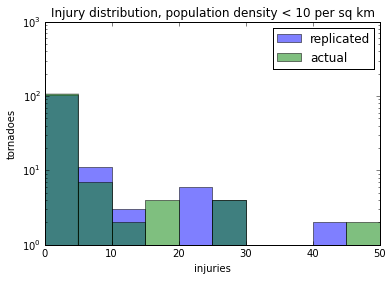

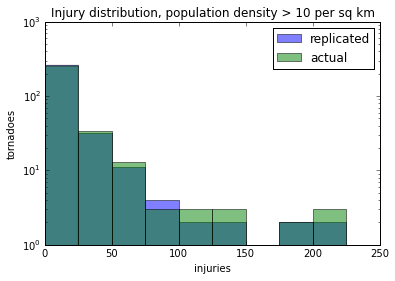

In [18]:
i = np.random.randint(1000)
const_factor = extract['const_factor'][i]
noise_factor = extract['noise_factor'][i]
#noise_factor = np.random.normal(scale=extract['noise_hp_sig'][i], size=torndatasel.index.size)
predinjuries = torndatasel['pop_dens'].values * np.exp(const_factor)
lambdas = torndatasel['pop_dens'].values * np.exp(const_factor + noise_factor)
injuries = np.random.poisson(lam=lambdas)
print "Predicted injuries:", np.sum(injuries)
print "Actual injuries:", np.sum(torndatasel['inj'].values)
plt.hist(injuries, log=True, alpha=0.5, range=(0,250), label='replicated')
plt.hist(torndatasel['inj'].values, log=True, alpha=0.5, range=(0,250), label='actual')
plt.xlabel('injuries')
plt.ylabel('tornadoes')
plt.legend()
plt.title('Injury distribution, all tornadoes')
plt.show()
plt.hist(injuries[torndatasel['pop_dens'].values < 1e-5], log=True, alpha=0.5, range=(0,50), label='replicated')
plt.hist(torndatasel['inj'].values[torndatasel['pop_dens'].values < 1e-5], log=True, alpha=0.5, range=(0,50), label='actual')
plt.xlabel('injuries')
plt.ylabel('tornadoes')
plt.legend()
plt.title('Injury distribution, population density < 10 per sq km')
plt.show()
plt.hist(injuries[torndatasel['pop_dens'].values > 1e-5], log=True, alpha=0.5, range=(0,250), label='replicated')
plt.hist(torndatasel['inj'].values[torndatasel['pop_dens'].values > 1e-5], log=True, alpha=0.5, range=(0,250), label='actual')
plt.xlabel('injuries')
plt.ylabel('tornadoes')
plt.legend()
plt.title('Injury distribution, population density > 10 per sq km')
plt.show()